In [96]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from collections import OrderedDict
from operator import itemgetter
from plotly.subplots import make_subplots
from sklearn import svm, tree 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import prince
from prince import MCA 

In [97]:
df = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')
df

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,LGG,TCGA-LGG,TCGA-DU-8164,Male,51 years 108 days,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,LGG,TCGA-LGG,TCGA-QH-A6CY,Male,38 years 261 days,Mixed glioma,white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,LGG,TCGA-LGG,TCGA-HW-A5KM,Male,35 years 62 days,"Astrocytoma, NOS",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,LGG,TCGA-LGG,TCGA-E1-A7YE,Female,32 years 283 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,LGG,TCGA-LGG,TCGA-S9-A6WG,Male,31 years 187 days,"Astrocytoma, anaplastic",white,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,GBM,TCGA-GBM,TCGA-19-5959,Female,77 years 325 days,Glioblastoma,white,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
858,GBM,TCGA-GBM,TCGA-16-0846,Male,85 years 65 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
859,GBM,TCGA-GBM,TCGA-28-1746,Female,77 years 178 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
860,GBM,TCGA-GBM,TCGA-32-2491,Male,63 years 121 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


## Data preprocessing

In [98]:
for i in df.columns:
    print(f'for column {i} unique values are: {df[i].unique()}')

for column Grade unique values are: ['LGG' 'GBM']
for column Project unique values are: ['TCGA-LGG' 'TCGA-GBM']
for column Case_ID unique values are: ['TCGA-DU-8164' 'TCGA-QH-A6CY' 'TCGA-HW-A5KM' 'TCGA-E1-A7YE'
 'TCGA-S9-A6WG' 'TCGA-DB-A4X9' 'TCGA-P5-A5F4' 'TCGA-FG-A4MY'
 'TCGA-HT-A5R5' 'TCGA-DU-A76K' 'TCGA-QH-A6CV' 'TCGA-FG-5962'
 'TCGA-DU-6402' 'TCGA-DB-A75M' 'TCGA-DB-A4XG' 'TCGA-DU-5851'
 'TCGA-DB-A4XH' 'TCGA-HT-7874' 'TCGA-DH-A66D' 'TCGA-DU-5871'
 'TCGA-FG-A60J' 'TCGA-E1-A7Z3' 'TCGA-DU-7011' 'TCGA-VW-A8FI'
 'TCGA-DU-A7TB' 'TCGA-HT-7856' 'TCGA-TQ-A7RU' 'TCGA-HW-7486'
 'TCGA-DU-6399' 'TCGA-DU-A7TA' 'TCGA-HT-A5RA' 'TCGA-DB-5280'
 'TCGA-DU-6405' 'TCGA-S9-A7J1' 'TCGA-S9-A7J2' 'TCGA-HW-7495'
 'TCGA-FG-A710' 'TCGA-P5-A5ET' 'TCGA-DU-7300' 'TCGA-DU-A5TY'
 'TCGA-VM-A8CH' 'TCGA-R8-A6YH' 'TCGA-S9-A6WE' 'TCGA-HT-7681'
 'TCGA-KT-A7W1' 'TCGA-FG-5964' 'TCGA-S9-A6TX' 'TCGA-P5-A5F2'
 'TCGA-DU-5874' 'TCGA-DU-A5TT' 'TCGA-CS-5396' 'TCGA-DU-7302'
 'TCGA-S9-A6TW' 'TCGA-RY-A845' 'TCGA-HT-A61A' 'TCGA-DU-70

In [99]:
# Replacing categorical variables with binary
df.replace({'MUTATED': 1, 'NOT_MUTATED': 0, 'Female': 1, 'Male': 0, 'LGG': 0, 'GBM': 1}, inplace=True)

In [100]:
# Removing rows with not identified variables
df = df[ (df['Gender'] != '--') & (df['Race'] != 'not reported')]

In [101]:
# Dropping unnessecary columns
df.drop(columns=(['Case_ID', 'Project', 'Primary_Diagnosis']), inplace=True)

In [102]:
# One hot encoding for race column
df = pd.concat([df, pd.get_dummies(df['Race'], prefix='Race')], axis=1)
df.drop(columns=['Race'], inplace=True)
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,51 years 108 days,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,38 years 261 days,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,35 years 62 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,32 years 283 days,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,31 years 187 days,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,77 years 325 days,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,85 years 65 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,77 years 178 days,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,63 years 121 days,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [103]:
# Converting column 'Age_at_diagnosis' to numerical data
data = []
years = pd.DataFrame(data)
# Creating new dataframe where Age column is split by ' ', unnecessary columns are deleted, years and days are added together
years = df['Age_at_diagnosis'].str.split(' ', expand=True)
years.drop(columns=[1, 3], inplace=True) # Dropping unnecessary columns (with words years and days)
years[0] = pd.to_numeric(years[0], errors='coerce') # Converting years to numerical data
years[2] = pd.to_numeric(years[2], errors='coerce') # Converting days to numerical data
years[0] = years[0] + years[2]
years[2] = round(years[2] / 365, 2)
# Old column is replaced with a new one
df['Age_at_diagnosis'] = years[0]
df

,Grade,Gender,Age_at_diagnosis,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,159.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,299.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,97.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,315.0,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,218.0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,402.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,150.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,255.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,184.0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [104]:
# Imputing missing age values w mean and not median bc boxplot shows no outliers
df.rename(columns={'Age_at_diagnosis': 'Age'}, inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)
df.describe()

,Grade,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,230.388292,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,104.085877,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,141.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,230.194146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,318.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,433.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='Age'>

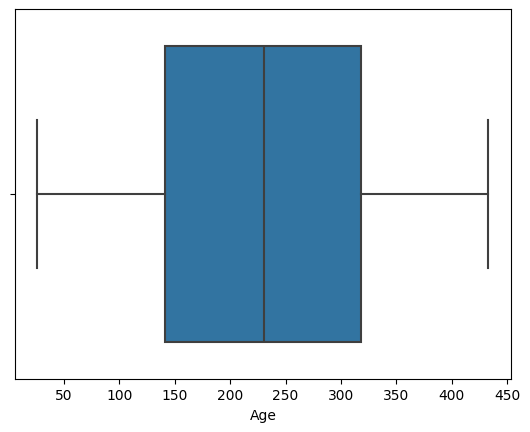

In [105]:
# Distribution of age to see if there are any outliers
sns.boxplot(data=df, x='Age')

In [106]:
# Normalizing age
df['Age'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df

,Grade,Gender,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
0,0,0,-0.685860,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.659184,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.281522,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0.812903,1,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,0,-0.119020,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,1,1,1.648751,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
858,1,0,-0.772327,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
859,1,1,0.236456,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
860,1,0,-0.445673,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [107]:
# Descriptive statistics
df.describe()

,Grade,Age,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,...,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_white
count,840.000000,8.400000e+02,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,...,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000,840.000000
mean,0.419048,-3.045183e-16,0.482143,0.414286,0.258333,0.167857,0.133333,0.132143,0.116667,0.086905,...,0.032143,0.032143,0.032143,0.027381,0.027381,0.026190,0.001190,0.016667,0.070238,0.911905
std,0.493697,1.000000e+00,0.499979,0.492892,0.437979,0.373962,0.340137,0.338848,0.321214,0.281863,...,0.176484,0.176484,0.176484,0.163288,0.163288,0.159797,0.034503,0.128095,0.255700,0.283602
min,0.000000,-1.963651e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-8.587937e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,-1.865246e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,8.417252e-01,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.946582e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data visualization 

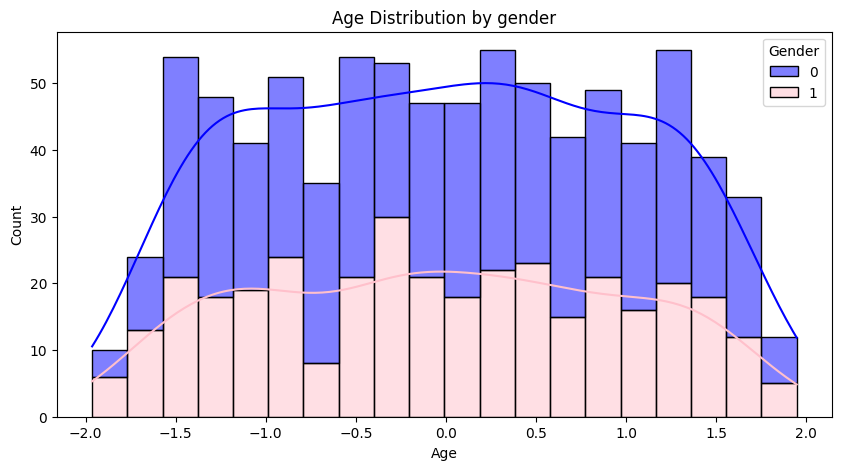

In [108]:
# Checking age distribution by gender
plt.figure(figsize=(10, 5))
sns.histplot(x='Age', data=df, hue='Gender', palette={0: 'blue', 1: 'pink'}, multiple='stack', bins=20, kde=True)
plt.title('Age Distribution by gender')
plt.show()

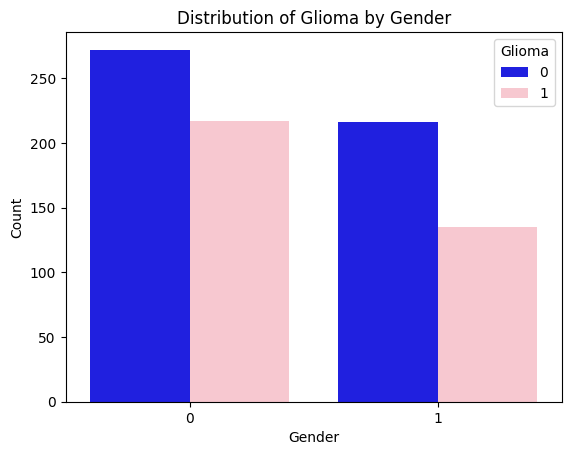

In [109]:
# Checking distribution of glioma by gender
sns.countplot(data=df, x='Gender', hue='Grade', palette={0: 'blue', 1: 'pink'})

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Glioma by Gender')
plt.legend(title='Glioma')

plt.show()

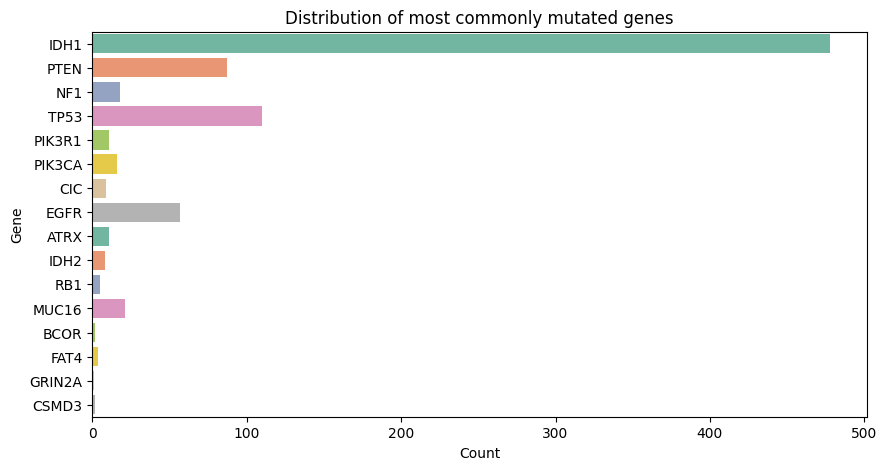

In [110]:
# Distribution of most commonly mutated genes
df['Most_commonly_mutated_gene'] = df.iloc[:, 3:-5].idxmax(axis=1)
plt.figure(figsize=(10, 5))

sns.countplot(data=df, y='Most_commonly_mutated_gene', palette='Set2')
plt.xlabel('Count')
plt.ylabel('Gene')
plt.title('Distribution of most commonly mutated genes')
plt.show()

comment: Results: We identified mutations that affected amino acid 132 of IDH1 in more than 70% of WHO grade II and III astrocytomas and oligodendrogliomas and in glioblastomas that developed from these lower-grade lesions. Tumors without mutations in IDH1 often had mutations affecting the analogous amino acid (R172) of the IDH2 gene. Tumors with IDH1 or IDH2 mutations had distinctive genetic and clinical characteristics, and patients with such tumors had a better outcome than those with wild-type IDH genes. Each of four tested IDH1 and IDH2 mutations reduced the enzymatic activity of the encoded protein.

In [111]:
# Value counts for most commonly mutated genes
fig = make_subplots(rows=5, cols=4)

# Loop through columns 3 to 22 (indexing from 0 to 19)
column_names = []  # List to store column names for legend

for i, column in enumerate(df.iloc[:, 3:23].columns, start=1):
    row_num = (i - 1) // 4 + 1  # Calculate row number
    col_num = (i - 1) % 4 + 1   # Calculate column number

    value_counts = df[column].value_counts()

    fig.add_trace(
        go.Bar(x=value_counts.index, y=value_counts.values),
        row=row_num, col=col_num
    )
    
    column_names.append(f'Column {column}')  # Store column names for legend

    fig.update_xaxes(title_text=f'{column}', row=row_num, col=col_num)  # X-axis title

# Update layout for all subplots
fig.update_layout(title='Value Counts for Columns 3 to 22', width = 1000, height = 1200)
fig.for_each_trace(lambda trace: trace.update(name=column_names.pop(0)))  # Update trace names using stored column names
fig.show()

Explains why IDH1 mutations so prevalent (boxplot balanced). Also expect that correlation matrix will show inv corrs between idh1 and idh2

Other mutations imbalanced bc not all gliomas have all mutated genes

<Axes: >

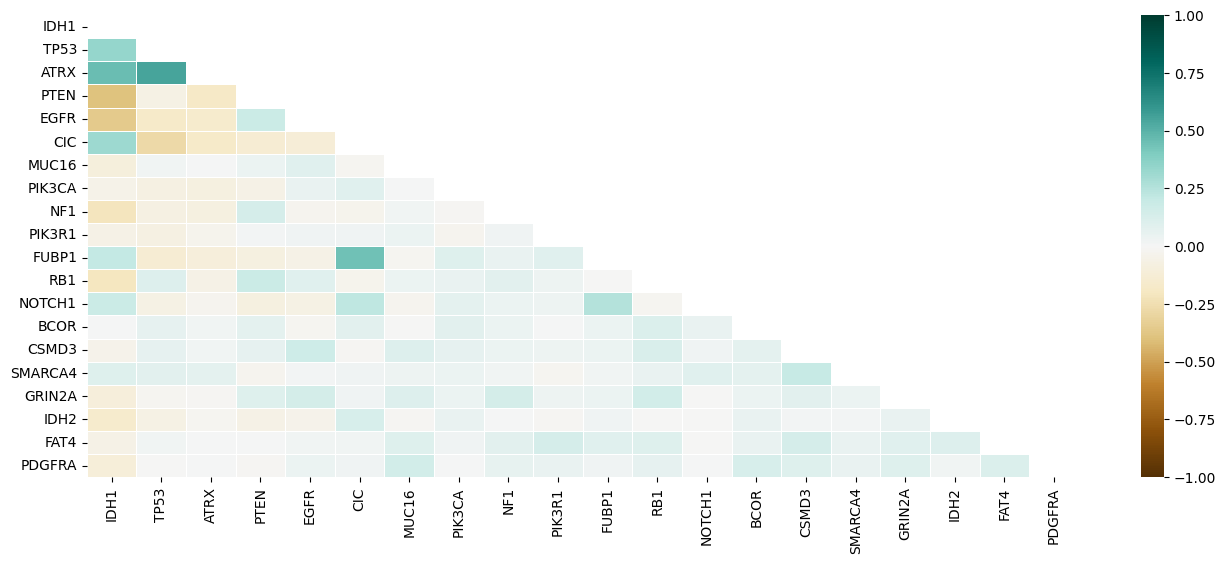

In [112]:
# Visualization of correlation between variables
plt.figure(figsize=(16, 6))
corr = df.iloc[:, 3 : 23].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

# Using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

In [113]:
# MCA analysis on genes
genes = df.iloc[:, 3:-5]
mca = prince.MCA(one_hot=False)
mca = prince.MCA(n_components=2).fit(genes)
mca.plot(genes)

alt.LayerChart(...)

In [114]:
# Eigenvalues
print("Eigenvalues:", mca.eigenvalues_)

# Row coordinates
print("Row coordinates:")
print(mca.row_coordinates(genes))

# Column coordinates
print("Column coordinates:")
print(mca.column_coordinates(genes))

Eigenvalues: [0.12035598 0.10021959]
Row coordinates:
            0         1
0   -0.163437  0.662502
1   -0.205770  0.394445
2   -0.463021 -0.291719
3   -0.178596 -0.119693
4   -0.463021 -0.291719
..        ...       ...
857  0.330845 -0.091745
858  0.191994 -0.263655
859  0.191994 -0.263655
860  0.324550 -0.135052
861  0.120239 -0.014922

[840 rows x 2 columns]
Column coordinates:
                  0         1
IDH1_0     0.826103 -0.143028
IDH1_1    -0.887296  0.153623
TP53_0     0.399129  0.450928
TP53_1    -0.564285 -0.637519
ATRX_0     0.353949  0.248192
ATRX_1    -1.016176 -0.712550
PTEN_0    -0.245287  0.081647
PTEN_1     1.215997 -0.404761
EGFR_0    -0.207905  0.034312
EGFR_1     1.351381 -0.223026
CIC_0      0.072494 -0.303301
CIC_1     -0.476112  1.991950
MUC16_0   -0.066849  0.020464
MUC16_1    0.506146 -0.154938
PIK3CA_0  -0.027245 -0.080195
PIK3CA_1   0.286256  0.842596
NF1_0     -0.089780 -0.019481
NF1_1      1.035819  0.224761
PIK3R1_0  -0.031740 -0.037785
PIK3R1_1   0.4

In [115]:
# Explained variance by each column
mca.column_contributions_.style.format('{:.0%}')

,0,1
IDH1_0,15%,1%
IDH1_1,16%,1%
TP53_0,4%,6%
TP53_1,5%,8%
ATRX_0,4%,2%
ATRX_1,11%,7%
PTEN_0,2%,0%
PTEN_1,10%,1%
EGFR_0,2%,0%
EGFR_1,10%,0%


## Model Selection

In [116]:
# Remove column 'most commonly mutated genes' from dataframe before fitting model, otherwise string error
df = df.iloc[:, :-16]

In [117]:
# Define label and features
X = df.drop(columns=['Grade'])
y = df['Grade']
y.value_counts()

0    488
1    352
Name: Grade, dtype: int64

In [118]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [119]:
# Creating a list of potential models: 
models = []
model1 = LogisticRegression()
models.append(model1)
model2 = svm.SVC()
models.append(model2)
model3 = tree.DecisionTreeClassifier()
models.append(model3)
model4 = RandomForestClassifier()
models.append(model4)
model5 = AdaBoostClassifier()
models.append(model5)

LogisticRegression()
Accuracy of LogisticRegression() is 0.8571428571428571
Recall (sensitivity) of LogisticRegression() is 0.9217391304347826


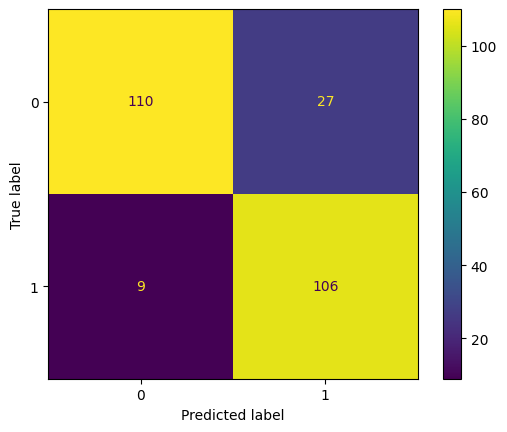

ROC AUC score of LogisticRegression() is 0.8623294192319899


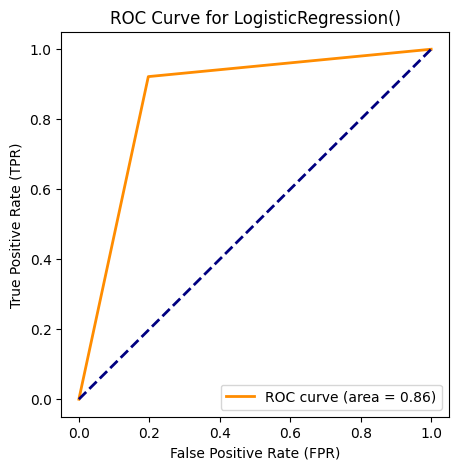

-------------------------------------------------------
SVC()
Accuracy of SVC() is 0.8531746031746031
Recall (sensitivity) of SVC() is 0.9304347826086956


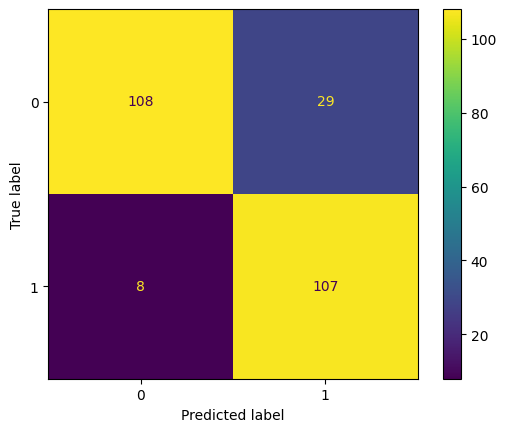

ROC AUC score of SVC() is 0.8593779752459536


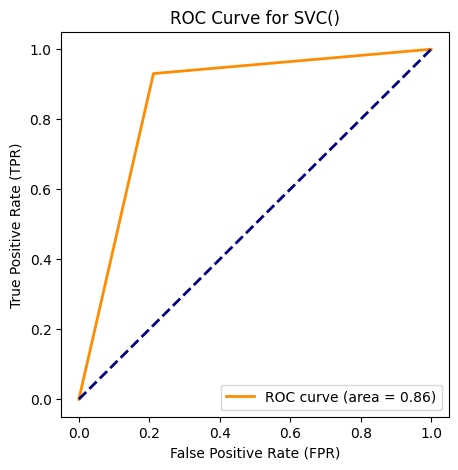

-------------------------------------------------------
DecisionTreeClassifier()
Accuracy of DecisionTreeClassifier() is 0.7579365079365079
Recall (sensitivity) of DecisionTreeClassifier() is 0.7565217391304347


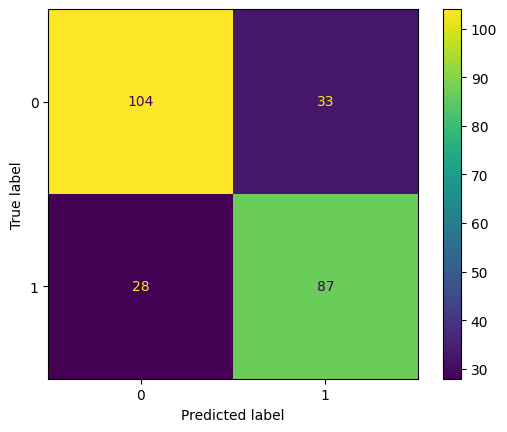

ROC AUC score of DecisionTreeClassifier() is 0.7578229133608378


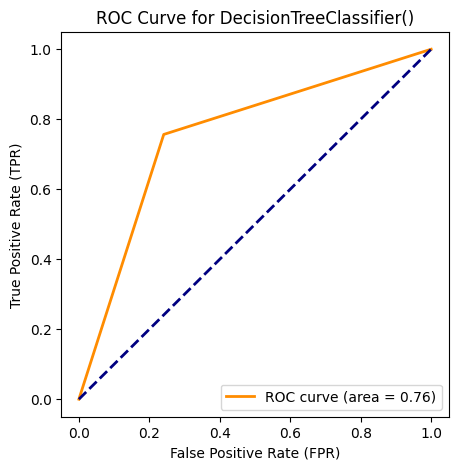

-------------------------------------------------------
RandomForestClassifier()
Accuracy of RandomForestClassifier() is 0.7658730158730159
Recall (sensitivity) of RandomForestClassifier() is 0.7913043478260869


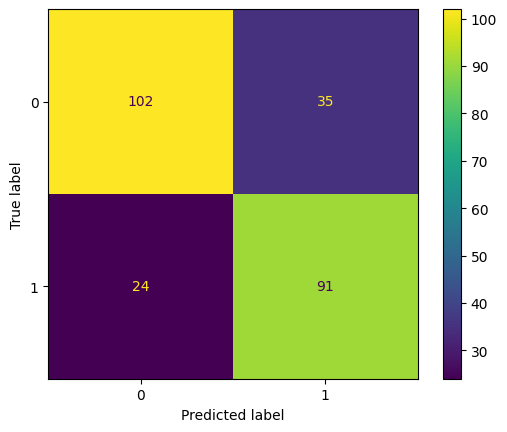

ROC AUC score of RandomForestClassifier() is 0.7679149476356711


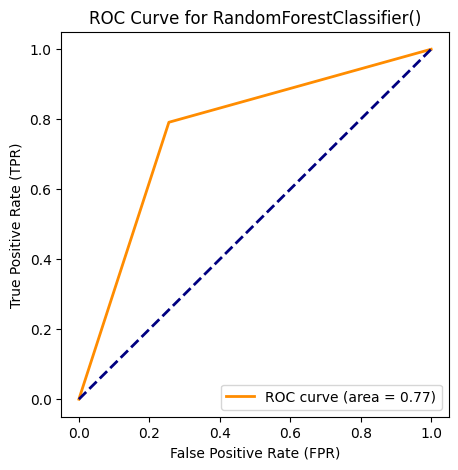

-------------------------------------------------------
AdaBoostClassifier()
Accuracy of AdaBoostClassifier() is 0.8253968253968254
Recall (sensitivity) of AdaBoostClassifier() is 0.8347826086956521


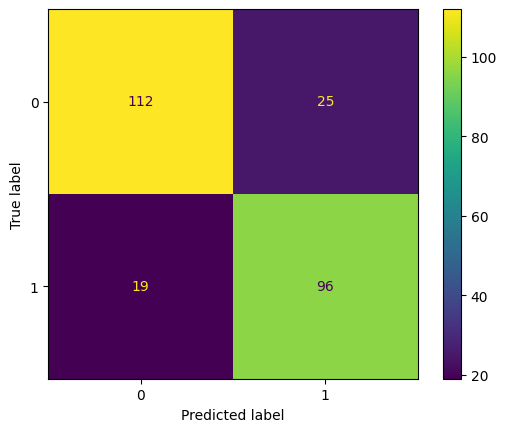

ROC AUC score of AdaBoostClassifier() is 0.8261504284354173


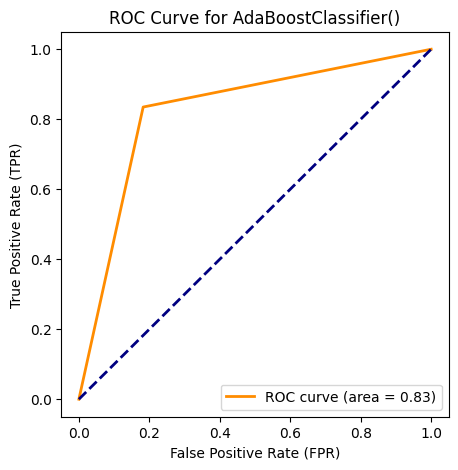

-------------------------------------------------------


In [120]:
dict = {} # Creating dict for storing model's accuracy 

# Model evaluation with accuracy, cm, f1, roc scores
for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    dict[model] = round(recall, 2) # Add key-value pair to the dictionary
    print(f"Accuracy of {model} is {accuracy}")
    print(f'Recall (sensitivity) of {model} is {recall}')

    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
    disp.plot()
    plt.show()

    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC score of {model} is {roc_auc}")

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for {model}')
    plt.legend(loc='lower right')
    plt.show()
    print("-------------------------------------------------------")

In [121]:
# Getting first two models with the best recall
sorted_dict = OrderedDict(sorted(dict.items(), key = itemgetter(1), reverse = True))
first2pairs = {k: sorted_dict[k] for k in list(sorted_dict)[:2]}
print(f'The two models with best recall are {first2pairs}')

The two models with best recall are {SVC(): 0.93, LogisticRegression(): 0.92}


In [122]:
# Removing models from models list that didnt performe well
keys = first2pairs.keys()
models = [model for model in models if model in keys]
models

[LogisticRegression(), SVC()]

## Cross validation for both models, accuracy and recall

In [123]:
# Cross validation (ACCURACY, keeping for paper comparison)
splits = [5, 10] # Trying 5 and 10 folds
dict_cv_accuracy = {} # Creating dict for storing model's accuracy
dict_cv_recall = {} # Creating dict for storing model's recall
for i in splits:
    kf = KFold(n_splits = i, shuffle = True, random_state = 42)
    for model in models:
        name = '{}_{}'.format(model, i)
        accuracy = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy').mean()
        dict_cv_accuracy[name] = accuracy
        recall = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall').mean()
        dict_cv_recall[name] = recall
        print(f'''
                Accuracy of {model} for {i} splits is {round(accuracy.mean(), 5)} 
                Recall of {model} for {i} splits is {round(recall.mean(), 5)} 
            ''')
    print("                ---------------------------------------------------------------")


                Accuracy of LogisticRegression() for 5 splits is 0.84714 
                Recall of LogisticRegression() for 5 splits is 0.89341 
            



                Accuracy of SVC() for 5 splits is 0.85905 
                Recall of SVC() for 5 splits is 0.91671 
            
                ---------------------------------------------------------------

                Accuracy of LogisticRegression() for 10 splits is 0.8505 
                Recall of LogisticRegression() for 10 splits is 0.91055 
            

                Accuracy of SVC() for 10 splits is 0.85903 
                Recall of SVC() for 10 splits is 0.91809 
            
                ---------------------------------------------------------------


In [124]:
# Getting first two models with the best accuracy
sorted_dict_cv = OrderedDict(sorted(dict_cv_accuracy.items(), key = itemgetter(1), reverse = True))
sorted_dict_cv

OrderedDict([('SVC()_5', 0.8590467912501811),
             ('SVC()_10', 0.8590298071303332),
             ('LogisticRegression()_10', 0.8504967855055522),
             ('LogisticRegression()_5', 0.8471389251050268)])

In [125]:
# Getting first two models with the best recall
sorted_dict_cv = OrderedDict(sorted(dict_cv_recall.items(), key = itemgetter(1), reverse = True))
sorted_dict_cv

OrderedDict([('SVC()_10', 0.9180916305916306),
             ('SVC()_5', 0.9167145761854087),
             ('LogisticRegression()_10', 0.9105461760461762),
             ('LogisticRegression()_5', 0.8934060736617546)])

# Logistic regression

## GridSearch for Logistic Regression, accuracy

In [126]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation score: 0.8539330725771404


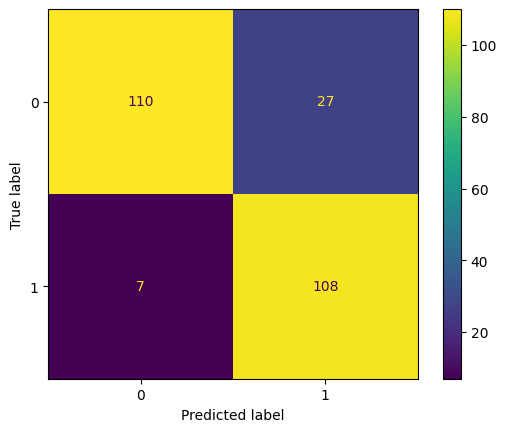

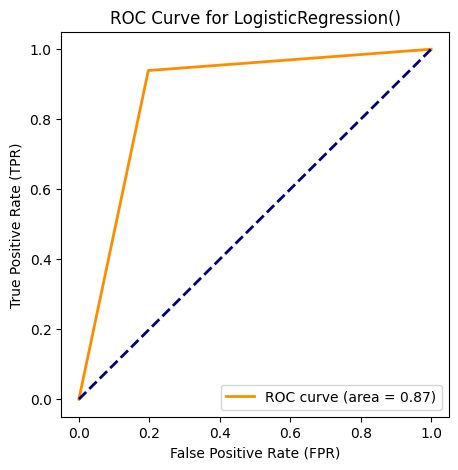

Accuracy of new LogisticRegression is 0.8650793650793651


In [129]:
# y_pred with the best parameters from GridSearchCV
y_pred_accuracy = best_model.predict(X_test)

accuracy_gs = accuracy_score(y_test, y_pred_accuracy)
cm = confusion_matrix(y_test, y_pred_accuracy, labels = models[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_accuracy)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new LogisticRegression is {accuracy_gs}")

In [130]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_gs > prev_accuracy:
    print("Accuracy improved after GridSearch")
    print(f'GridSearch accuracy is {accuracy_gs}')
else: 
    print("Accuracy did not improve after gridsearch")

Previous accuracy of LogisticRegression is 0.8571428571428571
Accuracy improved after gridsearch
GridSearch accuracy is 0.8650793650793651


## RandomSearch for Logistic Regression, accuracy

In [131]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'accuracy',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'sag', 'penalty': 'none', 'C': 1438.44988828766}
Best cross-validation score: 0.8471244386498622


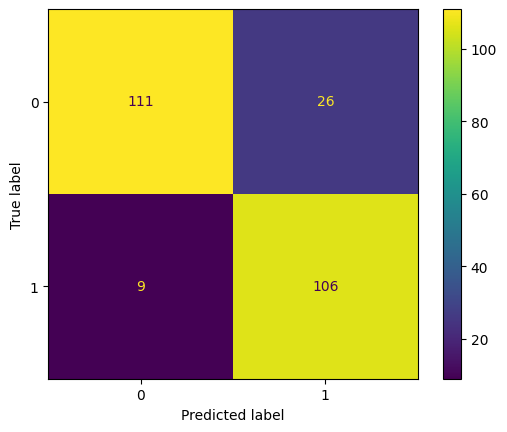

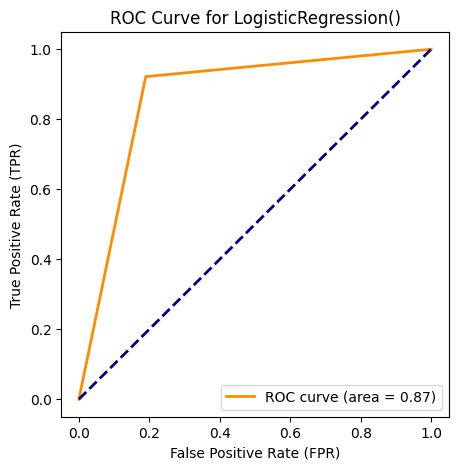

Accuracy of new LogisticRegression is 0.8611111111111112


In [132]:
#now use best parameters from random search to predict y_pred

y_pred_accuracy_rs = best_model_rs.predict(X_test)

accuracy_rs = accuracy_score(y_test, y_pred_accuracy_rs)
cm_rs = confusion_matrix(y_test, y_pred_accuracy_rs, labels = models[0].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_accuracy_rs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new LogisticRegression is {accuracy_rs}")

In [133]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if accuracy_rs > prev_accuracy:
    print("Accuracy improved after Random Search")
    print(f'Random Search accuracy is {accuracy_rs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous accuracy of LogisticRegression is 0.8571428571428571
Accuracy improved after Random Search
Random Search accuracy is 0.8611111111111112


________________________________________________________________________________________________________________________

## GridSearch for logistic regression, recall

In [134]:
kf = KFold(n_splits = 10, shuffle=True, random_state=42)

# GridSearchCV for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20), #more granular params bc evenly dsitributed in logspace
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

grid_search = GridSearchCV(estimator = models[0],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.03359818286283781, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.9316370851370852


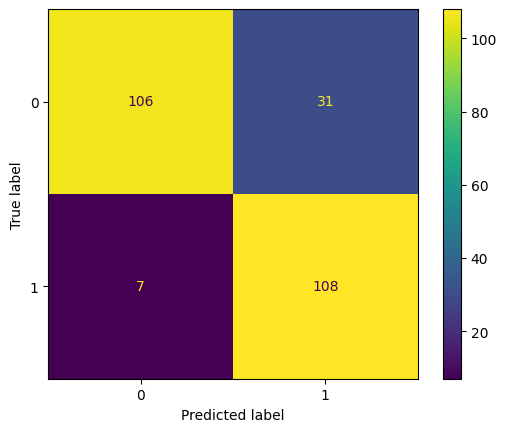

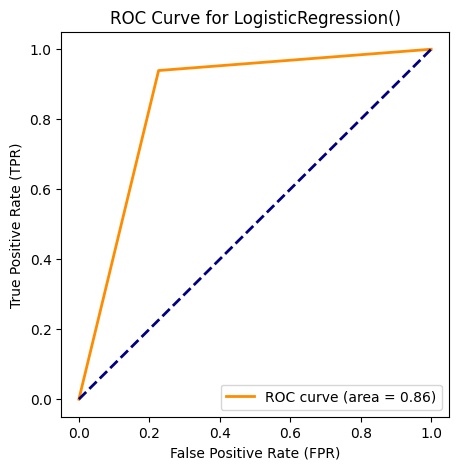

Recall of new LogisticRegression is 0.9391304347826087


In [135]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[0].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Recall of new LogisticRegression is {recall_gs}")

In [149]:
y_pred = models[0].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of LogisticRegression is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Accuracy improved after GridSearch")
    print(f'Random Search accuracy is {recall_gs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous recall of LogisticRegression is 0.9217391304347826
Accuracy improved after GridSearch
Random Search accuracy is 0.9391304347826087


## RandomSearch for Logistic Regression, recall

In [137]:
#Randomsearch for logistic regression

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 20),
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

randomized_search = RandomizedSearchCV(estimator = models[0],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model_rs = randomized_search.best_estimator_

print(f"Best parameters: {randomized_search.best_params_}")
print(f"Best cross-validation score: {randomized_search.best_score_}")

Best parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 29.763514416313132}
Best cross-validation score: 0.8988080808080807


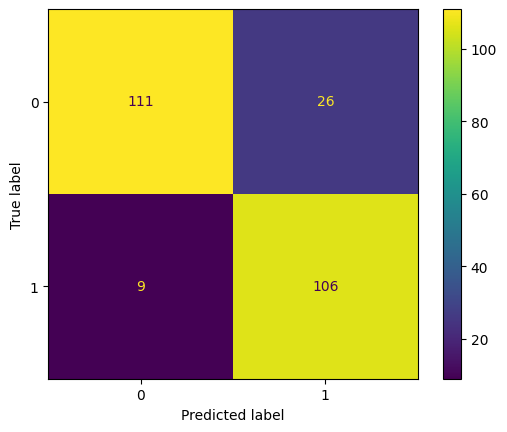

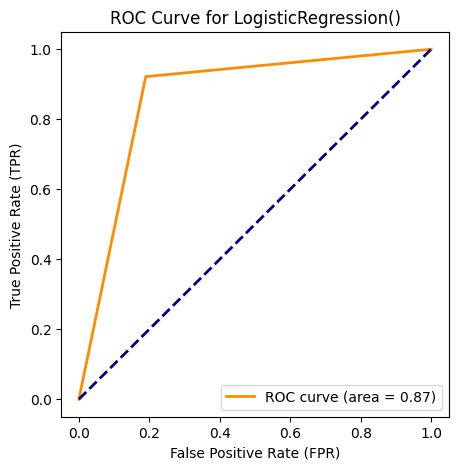

Accuracy of new LogisticRegression is 0.8611111111111112


In [139]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)

recall_rs = accuracy_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[0].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[0].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall_rs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[0]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new LogisticRegression is {recall_rs}")

In [140]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of LogisticRegression is {prev_accuracy}")

if recall_rs > prev_accuracy:
    print("Accuracy improved after Random Search")
    print(f'Random Search accuracy is {recall_rs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous accuracy of LogisticRegression is 0.8571428571428571
Accuracy improved after Random Search
Random Search accuracy is 0.8611111111111112


# SVM

## GridSearch for SVM, recall

In [144]:
kf = KFold(n_splits = 10, shuffle=True, random_state=42)

# GridSearchCV for SVM

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator = models[1],
                           param_grid = param_grid,
                           scoring = 'recall',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9316370851370852


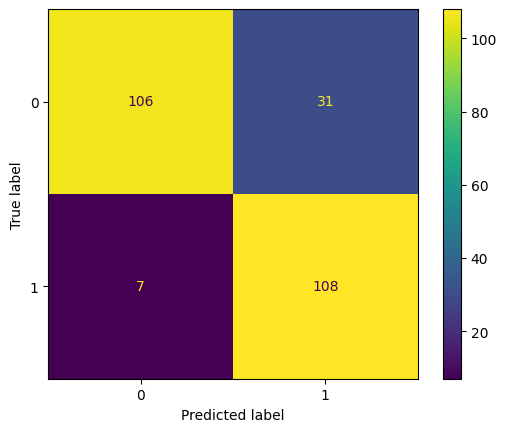

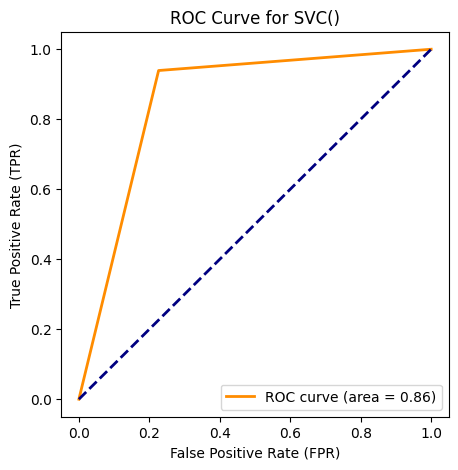

Recall of new SVC() is 0.9391304347826087


In [153]:
# y_pred with the best recall parameters from GridSearchCV
y_pred_recall = best_model.predict(X_test)

recall_gs = recall_score(y_test, y_pred_recall)
cm = confusion_matrix(y_test, y_pred_recall, labels = models[1].classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = models[1].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[1]}')
plt.legend(loc='lower right')
plt.show()
print(f"Recall of new {models[1]} is {recall_gs}")

In [154]:
y_pred = models[1].predict(X_test)
prev_accuracy = recall_score(y_test, y_pred)
print(f"Previous recall of {models[1]} is {prev_accuracy}")

if recall_gs > prev_accuracy:
    print("Accuracy improved after GridSearch")
    print(f'Random Search accuracy is {recall_gs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous recall of SVC() is 0.9304347826086956
Accuracy improved after GridSearch
Random Search accuracy is 0.9391304347826087


## RandomSearch for SVM, recall

In [155]:
kf = KFold(n_splits = 10, shuffle=True, random_state=42)

# RandomSearch for SVM

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search = RandomizedSearchCV(estimator = models[1],
                           param_distributions = param_grid,
                           scoring = 'recall',
                           cv = kf).fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'kernel': 'sigmoid', 'gamma': 'auto', 'C': 1}
Best cross-validation score: 0.9316370851370852


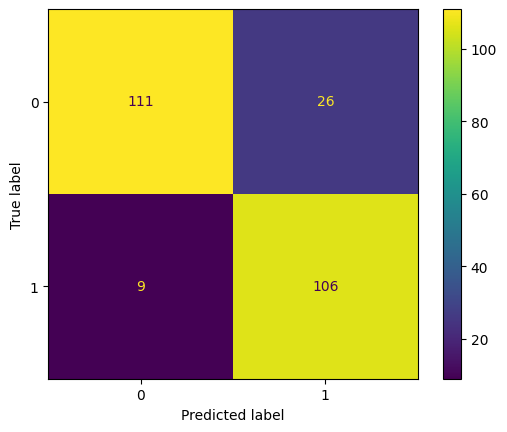

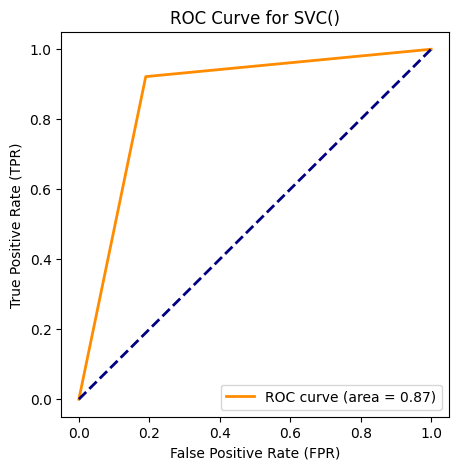

Accuracy of new SVC() is 0.8611111111111112


In [156]:
#now use best parameters from random search to predict y_pred

y_pred_recall_rs = best_model_rs.predict(X_test)

recall_rs = accuracy_score(y_test, y_pred_recall_rs)
cm_rs = confusion_matrix(y_test, y_pred_recall_rs, labels = models[1].classes_) 
disp = ConfusionMatrixDisplay(confusion_matrix = cm_rs, display_labels = models[1].classes_)
disp.plot()
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_recall_rs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for {models[1]}')
plt.legend(loc='lower right')
plt.show()
print(f"Accuracy of new {models[1]} is {recall_rs}")

In [157]:
y_pred = models[0].predict(X_test)
prev_accuracy = accuracy_score(y_test, y_pred)
print(f"Previous accuracy of {models[1]} is {prev_accuracy}")

if recall_rs > prev_accuracy:
    print("Accuracy improved after Random Search")
    print(f'Random Search accuracy is {recall_rs}')
else: 
    print("Accuracy did not improve after Random Search")

Previous accuracy of SVC() is 0.8571428571428571
Accuracy improved after Random Search
Random Search accuracy is 0.8611111111111112


In [ ]:
#pick which best bewten rf and lr after hyperparametter turning

In [ ]:
#when found best params plt smth like this 


#Scatter plot for the actual training values
scatter = go.Scatter(x = x_train.values.flatten(), y=y_train.values.flatten(), mode='markers', name='Actual')
#line plot for the predicted training values
line = go.Scatter(x = x_train.values.flatten(), y=y_pred.values.flatten(), mode='lines', name='Predicted')
layout = go.Layout(title='Actual vs Predicted, train set', xaxis=dict(title='population'), yaxis=dict(title='profit'))
data = [scatter, line]
figtr = go.Figure(data=data, layout=layout)
figtr.show()


#predict new values based on the test set


#scatter for  y test values
scatter = go.Scatter(x = x_test.values.flatten(), y=y_test.values.flatten(), mode='markers', name='Actual')
#line for predicted y values 
line = go.Scatter(x = x_test.values.flatten(), y=new_y.values.flatten(), mode='lines', name='Predicted')
layout = go.Layout(title='Actual vs Predicted, test set', xaxis=dict(title='population'), yaxis=dict(title='profit'))
data = [scatter, line]
figte = go.Figure(data=data, layout=layout)
figte.show()


# Points to discuss

**EDA**

- check if shared things between na in age before just going w mean refill. are they actually outliers?

**Correlation matrix**

- look into who doesnt have mutations in idh1 and 2 -> is each of them related to a different glioma grade? 

- look at correlations of high values between themselves: are they more correlated to one specific form of glioma? we expect more associated with GBM based on literature 

**PCA**

- most correlated components in corr matrix are linked to GBM mostly, so can we still do PCA? can we cluster them?

**GRID SEARCH**

- random search outperforms grid search so try both. 


**Relevant notes on genes**

- p53: tumor suppressor gene, Dna damage and repair! mutations in p53 are associated with many cancers, including gliomas esp GBM

- grin2a: less involved in DNA repair, so mutation here is less bad 

- look at corrs between ATRX and p53, and are tehy linked to one specific kind of glioma more than others? 

- if highly correlated, check if they dont just exist in same place in dna

- atrx is chromosome x and p53 is chromosome 17, so they are not just in same place in dna -> can claim causation? 




<AxesSubplot:>

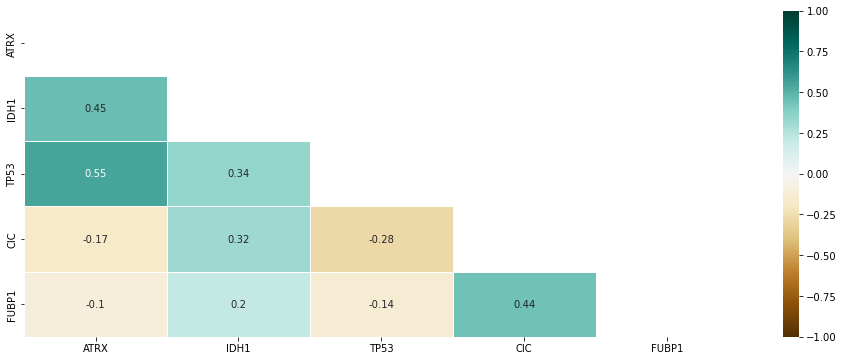

In [ ]:
# Plotting only genes that showed correlation among them, for better visualization
correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1']
plt.figure(figsize=(16, 6))
corr2 = df[correlated_genes].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix2 = np.triu(corr2)


sns.heatmap(corr2, annot=True, mask=matrix2, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

ATRX and IDH1 : 0.45

ATRX and TP53 : 0.55

IDH1 and TP53 : 0.34

CIC and FUBP1 : 0.44

CIC and IDH1 : 0.32 

All of these genes are fundamental in cancer development, they are involved in tasks such as cell division regulation, transcriptional repression, tumor growth interruption under unfavorable conditions (e.g. tumors), DNA structure modification. 

It is reasonable to expect that these genes would be most correlated to higher grades glioma. 
Need to determine whether this can be taken as enough evidence to "cluster" them and do PCA.


<AxesSubplot:>

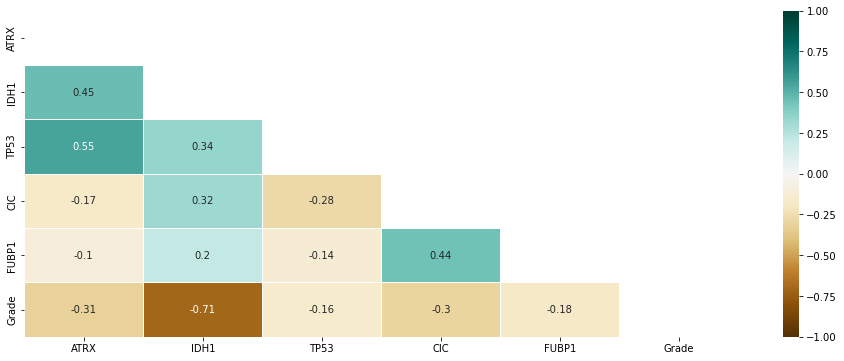

In [ ]:
# Plotting selected genes correlation with glioma grade 
plt.figure(figsize=(16, 6))
corr_genesglioma = correlated_genes = ['ATRX', 'IDH1', 'TP53', 'CIC', 'FUBP1' , 'Grade']
corr3 = df[corr_genesglioma].corr()

# Getting the Upper Triangle of the co-relation matrix
matrix3 = np.triu(corr3)


sns.heatmap(corr3, annot=True, mask=matrix3, vmin=-1, vmax=1, linewidths=.5, cmap='BrBG')

#stronger correlation means that if the genes are mutated, the grade is more likely to be GBM. This is because we assigned 1 to mutation and 1 to GBM.

In [ ]:
#compare w open source results and see if your accuracy is better
#dont divide mutations in 0 and 1
#threshold of each gene expression

we thought accuracy wouldnt be the best metrics, so we chose recall (sensitivity): the cost of misclassifying a GBM as a "simpler" LGG is very high, we really care about false negatives. A false negative here, since GBM is 1 and LGG is 0, is a classification of LGG which in reality should have been classified as GBM. 

AUC-ROC comparing classification ability between models. 



TODO: mention why didnt pick PCA (We think every feature is important)

TODO: ASk ossnat if we should use PCA

TODO: try random search as well as grid search https://www.kdnuggets.com/2022/10/hyperparameter-tuning-grid-search-random-search-python.html